# Imports

In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from time import sleep
import json
import os
import sys

import matplotlib.pyplot as plt
from scipy import signal, optimize
import matplotlib.image as mpimg
from labellines import *


%matplotlib qt


from tqdm import tqdm
from scipy.optimize import minimize

from scqubits import *
import scqubits
scqubits.settings.NUM_CPUS = 4
scqubits.settings.OVERLAP_THRESHOLD  = 0.0 #  In order to look for the indices

# Useful functions

In [65]:
def plot_extracted_points(figure, extracted_points):
    ax = fig.axes[0]
    flux_values = list(extracted_points.keys())
    for f in flux_values:
        list_transitions = list(extracted_points[f].keys())
        for t in list_transitions:
            ax.plot(f, extracted_points[f][t], marker='x', markersize=8, color="red")
    fig.canvas.draw_idle()

def remove_lines(figure):
    ax = fig.axes[0]
    try:
        ax.get_legend().remove()
    except:
        pass
    for i,l in enumerate(ax.lines):
        l.remove()
    fig.canvas.draw_idle()

def remove_label_lines(figure):
    ax = fig.axes[0]
    try:
        ax.get_label().remove()
    except:
        pass
    for i,l in enumerate(ax.lines):
        l.remove()
    fig.canvas.draw_idle()
    
# def plot_theory_lines(fig, parameters, transitions=["01","02","03","04","05","06","12","13","14","15","16","23","24","25","26","34","35","36","45","46",], **kwargs):
def plot_theory_lines(fig, parameters, transitions=["03","05","13","23"], **kwargs):
    ### Get parameters from kwargs
    if 'flux_values' in kwargs:
        flux_values = kwargs.get('flux_values')
    else:
        flux_values = np.linspace(-1.0, 1.0, 101)
        
    if 'cutoff' in kwargs:
        cutoff = kwargs.get('cutoff')
    else:
        cutoff = 110
        
    ### calculate the lines
    lines_toplot = {}
    for t in transitions:
        lines_toplot[t] = []
    for f in flux_values:
        fluxonium = Fluxonium(EJ=parameters['Ej']/1e9, EC=parameters['Ec']/1e9, EL=parameters['El']/1e9, flux=f, cutoff=cutoff,)
        osc = Oscillator(3.6, truncated_dim = 21)
        # osc = Oscillator(2.993, truncated_dim = 21)
        hilbertspace = HilbertSpace([fluxonium, osc])
        g1 = parameters['g']/1e9  # coupling resonator-tmon1 (without charge matrix elements)
        operator1 = fluxonium.n_operator
        operator2 = osc.annihilation_operator
        hilbertspace.add_interaction(
        g_strength=g1,
        op1=(operator1, fluxonium),
        op2=(operator2, osc),
        add_hc = True
        )
 
        dressed_hamiltonian = hilbertspace.hamiltonian()
        hilbertspace.generate_lookup()

        eigenenergies = dressed_hamiltonian.eigenenergies(0)
        for t in transitions:
            #lines_toplot[t].append(1e9*np.array([eigenenergies[int(t[1])] - eigenenergies[int(t[0])] for t in transitions]))
            lines_toplot[t].append(1e9*np.array([eigenenergies[int(t[1])] - eigenenergies[int(t[0])]]))
    
    ### Plotting the lines
    ax = fig.axes[0]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    current = phiext_to_current(flux_values, parameters)
    for t in transitions:
        ax.plot(current, lines_toplot[t], label=t)
        # first_part = str(hilbertspace.bare_index(int(t[0])))
        # second_part = str(hilbertspace.bare_index(int(t[1])))
        # transition_str = first_part + "->" + second_part
        # ax.plot(current, lines_toplot[t], label=transition_str)

    

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # labelLines(plt.gca().get_lines(), align=True, backgroundcolor="none",fontsize=6)
    ax.legend(loc='upper right')
    ax.set_title('Ej = {:.2f} GHz, Ec = {:.3f} GHz, El = {:.3f} GHz, g = {:.3f} GHz'.format(parameters['Ej']/1e9, parameters['Ec']/1e9, parameters['El']/1e9, parameters['g']/1e9))
    fig.canvas.draw_idle()

In [4]:
# def plot_theory_energies(fig, parameters, levels=["0","1","2","3","4","5",], **kwargs):
#     ### Get parameters from kwargs
#     if 'flux_values' in kwargs:
#         flux_values = kwargs.get('flux_values')
#     else:
#         flux_values = np.linspace(-1.0, 1.0, 101)
        
#     if 'cutoff' in kwargs:
#         cutoff = kwargs.get('cutoff')
#     else:
#         cutoff = 110
        
#     ### calculate the lines
#     energies_toplot = {}
#     for l in levels:
#         energies_toplot[l] = []
#     for f in flux_values:
#         fluxonium = Fluxonium(EJ=parameters['Ej']/1e9, EC=parameters['Ec']/1e9, EL=parameters['El']/1e9, flux=f, cutoff=cutoff,)
#         osc = Oscillator(3.85, truncated_dim = 21)
#         hilbertspace = HilbertSpace([fluxonium, osc])
#         g1 = parameters['g']/1e9  # coupling resonator-tmon1 (without charge matrix elements)
#         operator1 = fluxonium.n_operator()
#         operator2 = osc.creation_operator() + osc.annihilation_operator()
#         hilbertspace.add_interaction(
#         g=g1,
#         op1=(operator1, fluxonium),
#         op2=(operator2, osc)
#         )
#         dressed_hamiltonian = hilbertspace.hamiltonian()
#         # Edn.append(dressed_hamiltonian.eigenenergies(0)[:6])
#         # eigenenergies = fluxonium.diago()[0]
#         # eigenenergies = fluxonium.eigenvals()
#         eigenenergies = dressed_hamiltonian.eigenenergies(0)
#         for l in levels:
#             energies_toplot[l].append(1e9*np.array(eigenenergies[int(l)] ))
    
#     ### Plotting the lines
#     ax = fig.axes[0]
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
    
#     current = phiext_to_current(flux_values, parameters)
#     for l in levels:
#         ax.plot(current, energies_toplot[t], label = l)
#         # ax.plot(flux_values, np.array(lines_toplot[t])/1e9, label=t)
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     ax.legend(loc='upper right')
#     ax.set_title('Ej = {:.2f} GHz, Ec = {:.2f} GHz, El = {:.2f} GHz, g = {:.2f} MHz'.format(parameters['Ej']/1e9, parameters['Ec']/1e9, parameters['El']/1e9, parameters['g']/1e6))
#     fig.canvas.draw_idle()

In [5]:
def current_to_phiext(current_value, parameters):
    # return (current_value - parameters['current_integer_flux'])/(parameters['Amp_per_phi0'])
    return (current_value - current_integer_flux) / Amp_per_phi0

def phiext_to_current(phiext, parameters):
    # return phiext * parameters['Amp_per_phi0'] + parameters['current_integer_flux']
    return phiext * Amp_per_phi0 + current_integer_flux

def from_parameter_array_to_parameter_dict(parameter_array):
    # keys_list = ['Ej', 'Ec', 'El', 'Amp_per_phi0', 'current_integer_flux', 'g']
    keys_list = ['Ej', 'Ec', 'El', 'g']
    parameters = {k:parameter_array[i] for i,k in enumerate(keys_list)}
    return parameters

def cost_function(parameters, extracted_points, model, cost_type='absolute', **kwargs):    
    cost = 0
    current_values = list(extracted_points.keys())
    for c in current_values:
        transitions = list(extracted_points[c].keys())
        data = np.array([extracted_points[c][t] for t in transitions])
        fit = model(c, parameters, transitions, **kwargs)*1e9
        if cost_type=='absolute':
            cost += np.sum(np.abs(data - fit))/1e9
        elif ost_type=='relative':
            cost += np.sum(np.abs(data - fit))/data
    return cost

def model(current, parameters, transitions, **kwargs):
    if 'cutoff' in kwargs:
        cutoff = kwargs.get('cutoff')
    else:
        cutoff = 110
    # fluxonium = Fluxonium(EJ=parameters['Ej']/1e9, EC=parameters['Ec']/1e9, EL=parameters['El']/1e9, flux=current_to_phiext(current, parameters), cutoff=cutoff,)
    # eigenenergies = fluxonium.eigenvals()
    # eigenenergies = fluxonium.diago()[0]
    fluxonium = Fluxonium(EJ=parameters['Ej']/1e9, EC=parameters['Ec']/1e9, EL=parameters['El']/1e9, flux=current_to_phiext(current, parameters), cutoff=cutoff,)
    osc = Oscillator(3.6, truncated_dim = 21)
    # osc = Oscillator(2.993, truncated_dim = 21)
    hilbertspace = HilbertSpace([fluxonium, osc])
    g1 = parameters['g']/1e9  # coupling resonator-tmon1 (without charge matrix elements)
    operator1 = fluxonium.n_operator()
    operator2 = osc.creation_operator() + osc.annihilation_operator()
    hilbertspace.add_interaction(
    g=g1,
    op1=(operator1, fluxonium),
    op2=(operator2, osc)
    )
    dressed_hamiltonian = hilbertspace.hamiltonian()
    eigenenergies = dressed_hamiltonian.eigenenergies(0)
    return np.array([eigenenergies[int(t[1])] - eigenenergies[int(t[0])] for t in transitions])

def rescale_parameter_array(parameters_list):
    # return np.array(parameters_list*np.array([1e-9, 1e-9, 1e-9, 1e6, 1e6, 1e-9]))
    return np.array(parameters_list*np.array([1e-9, 1e-9, 1e-9, 1e-9]))

def unrescale_parameter_array(parameters_list):
    # return np.array(parameters_list*np.array([1e9, 1e9, 1e9, 1e-6, 1e-6, 1e9]))
    return np.array(parameters_list*np.array([1e9, 1e9, 1e9, 1e9]))

# Imports the data

Note you need to import and reshape the data. This section needs to be adapted based on how and with what instrument the data acquisition was made.

In [6]:
from labmate.acquisition_notebook import AcquisitionAnalysisManager
path_database = r'S:\__ExperimentalData\Ouroboros\Data\Labmate'
aqm = AcquisitionAnalysisManager(path_database)

In [7]:
data1 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_11__19_58_37__Two tones with ext. microwave src.h5")   # Full spectra
# exec(data1.configs['configuration.py'])

data2 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_14__10_56_45__Two tones with ext. microwave src.h5")     # Bigger scan on 3 GHz
# exec(data2.configs['configuration.py'])

# data3 = aqm.load_file(r"C:\Pydata\labmate\Two tones with ext. microwave src\2024_03_14__13_43_15__Two tones with ext. microwave src.h5")   # more zoom on 3 GHz
# exec(data3.configs['configuration.py'])

# data3 = aqm.load_file(r"C:\Pydata\labmate\Two tones with ext. microwave src\2024_03_14__20_56_50__Two tones with ext. microwave src.h5")      # More zoom on 3GHz but pulsed one
# exec(data3.configs['configuration.py'])


data3 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_15__17_16_51__Two tones with ext. microwave src.h5")      # More zoom on 3GHz but pulsed one
# exec(data3.configs['configuration.py'])

data4 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_15__00_35_05__Two tones with ext. microwave src.h5")      # 2.3GHz but pulsed one
# exec(data4.configs['configuration.py'])

data5 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_16__12_51_19__Two tones with ext. microwave src.h5")      # More zoom on 3GHz (on half flux) but pulsed one
# exec(data5.configs['configuration.py'])


data6 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_16__13_35_56__Two tones with ext. microwave src.h5")    
# exec(data6.configs['configuration.py'])


data7 = aqm.load_file(r"S:\__ExperimentalData\Ouroboros\Data\Labmate\Two tones with ext. microwave src\2024_03_17__11_59_53__Two tones with ext. microwave src.h5")      
# exec(data6.configs['configuration.py'])



In [8]:
def process_data(data):
    flux_list = data.flux
    frequency = data.frequencies
    I = data.I
    Q = data.Q

    flattened_I = I.flatten()
    flattened_Q = Q.flatten()

    # Convert results into Volts and normalize
    S = (flattened_I + 1j * flattened_Q)
    R = np.abs(S)  # Amplitude
    R_reshaped = R.reshape((len(flux_list), -1))
    mag = R.reshape((len(flux_list), -1))
    phase = np.angle(S)  # Phase
    phase_reshaped = phase.reshape((len(flux_list), -1))

    # Normalize data
    row_sums_R = R_reshaped.sum(axis=0)
    R_reshaped /= row_sums_R[np.newaxis, :]
    mag /= row_sums_R[np.newaxis, :]

    row_sums_phase = phase_reshaped.sum(axis=0)
    phase_reshaped /= row_sums_phase[np.newaxis, :]

    return flux_list, frequency, R_reshaped, mag, phase_reshaped

# Process data1
flux_list1, frequency1, R_reshaped1, mag1, phase_reshaped1 = process_data(data1)

# Process data2
flux_list2, frequency2, R_reshaped2, mag2, phase_reshaped2 = process_data(data2)

# Process data3
flux_list3, frequency3, R_reshaped3, mag3, phase_reshaped3 = process_data(data3)

# Process data4
flux_list4, frequency4, R_reshaped4, mag4, phase_reshaped4 = process_data(data4)

# Process data5
flux_list5, frequency5, R_reshaped5, mag5, phase_reshaped5 = process_data(data5)

# Process data6
flux_list6, frequency6, R_reshaped6, mag6, phase_reshaped6 = process_data(data6)

# Process data7
flux_list7, frequency7, R_reshaped7, mag7, phase_reshaped7 = process_data(data7)

# Plot the data

## Magnitude

In [64]:
plt.close()
fig = plt.figure(num = 1) # main dataset


def rescale_data(data, rescale=True):
    if rescale:
        return np.array([m - np.mean(m) for m in data])
    else:
        return data

# Assuming mag_normed, phase, mag1_normed, phase1, mag2_normed, phase2, mag3_normed, phase3 are defined

# Rescale the data
mag_rescaled1 = rescale_data(mag1)
phase_rescaled1 = rescale_data(phase_reshaped1)
mag_rescaled2 = rescale_data(mag2)
phase_rescaled2 = rescale_data(phase_reshaped2)
mag_rescaled3 = rescale_data(mag3)
phase_rescaled3 = rescale_data(phase_reshaped3)
mag_rescaled4 = rescale_data(mag4)
phase_rescaled4 = rescale_data(phase_reshaped4)
mag_rescaled5 = rescale_data(mag5)
phase_rescaled5 = rescale_data(phase_reshaped5)
mag_rescaled6 = rescale_data(mag6)
phase_rescaled6 = rescale_data(phase_reshaped6)
mag_rescaled7 = rescale_data(mag7)
phase_rescaled7 = rescale_data(phase_reshaped7)
    

# plt.pcolormesh(current, freq, mag_rescaled.T, vmin=-0.5e-3, vmax = 0.4e-3)
# plt.pcolormesh(decimated_flux_list, decimated_frequency, decimated_mag_rescaled.T, rasterized=True)

start = time.time()

# plt.pcolormesh(flux_list, frequency, mag_rescaled.T, rasterized=True)
# plt.pcolormesh(flux_list, frequency, mag.T, rasterized=True)



# Plot data using imshow

def plot_mag(mag_rescaled, flux_list, frequency, alpha = 1.0, vmin=None, vmax=None):
    # plt.figure()  # Create a new figure
    # plt.imshow(mag_rescaled.T, aspect='auto', origin='lower',
    #        extent=[flux_list.min(), flux_list.max(), frequency.min(), frequency.max()], rasterized=True)
    plt.pcolormesh(flux_list, frequency, mag_rescaled.T, shading='auto', cmap='viridis', rasterized=True, vmin=vmin, vmax=vmax,)


def plot_phase(phase_rescaled, flux_list, frequency, alpha = 1.0, vmin=None, vmax=None):
    # plt.figure()  # Create a new figure
    # plt.imshow(mag_rescaled.T, aspect='auto', origin='lower',
    #        extent=[flux_list.min(), flux_list.max(), frequency.min(), frequency.max()], rasterized=True)
    plt.pcolormesh(flux_list, frequency, phase_rescaled.T, shading='auto', cmap='viridis', rasterized=True, vmin=vmin, vmax=vmax,)

    # plt.imshow(mag_rescaled.T, aspect='auto', origin='lower',
    #        extent=[flux_list.min(), flux_list.max(), frequency.min(), frequency.max()], rasterized=True, vmin=-0.0005, vmax = 0.0005)

# plot_mag(mag_rescaled1, flux_list1, frequency1, alpha = 0.5, vmin = -0.0005, vmax = 0.0005)
# # plot_mag(mag_rescaled1, flux_list1, frequency1, alpha = 0.5)
# plot_mag(mag_rescaled2, flux_list2, frequency2, alpha = 0.5)
# plot_mag(mag_rescaled3, flux_list3, frequency3, alpha = 0.1)
# plot_mag(mag_rescaled4, flux_list4, frequency4, alpha = 0.1)

# plot_mag(phase_rescaled1, flux_list1, frequency1, alpha = 0.5, vmin = -0.0005, vmax = 0.0005)
# plot_mag(phase_rescaled2, flux_list2, frequency2, alpha = 0.1)
# plot_mag(phase_rescaled3, flux_list3, frequency3, alpha = 0.1)  # bit of vertical axis zoom
# plot_mag(phase_rescaled4, flux_list4, frequency4, alpha = 0.1)   # 2GHz
# plot_mag(phase_rescaled5, flux_list5, frequency5, alpha = 0.8)
# plot_mag(phase_rescaled6, flux_list6, frequency6, alpha = 0.1) 
# plot_mag(phase_rescaled7, flux_list7, frequency7, alpha = 0.1) 


### Code for just plotting a part of data 2

min_flux = 500
max_flux = 650
plot_mag(phase_rescaled1, flux_list1, frequency1, alpha = 0.5, vmin = -0.0005, vmax = 0.0005)
plot_mag(phase_rescaled2[min_flux:max_flux], flux_list2[min_flux:max_flux], frequency2, alpha = 0.1)
# plot_mag(phase_rescaled3, flux_list3, frequency3, alpha = 0.1)  # bit of vertical axis zoom

# plt.imshow(mag.T, aspect='auto', origin='lower',
#            extent=[flux_list.min(), flux_list.max(), frequency.min(), frequency.max()], rasterized=True,  vmin=0, vmax = 0.02)

stop = time.time()

print(stop-start)


cbar = plt.colorbar()
cbar.set_label("Magnitude (a.u)")
# plt.xlim(-0.125, 0.041358)
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (Hz)')
plt.title(r"$R=\sqrt{I^2 + Q^2}$ (normalized_Averaged)")
plt.tight_layout()
# plt.savefig('1500JJ1.jpg', dpi = 1000)

plt.show()

1.1551086902618408


## Phase

In [10]:
# plt.close()
# plt.figure

# rescale=True

# if rescale:
#     mag_rescaled = np.array([m-np.mean(m) for m in mag])
# else:
#     mag_rescaled = mag
    
# if rescale:
#     phase_rescaled = np.array([m-np.mean(m) for m in phase])
# else:
#     phase_rescaled = phase
    
    

# # plt.pcolormesh(current, freq, mag_rescaled.T, vmin=-0.5e-3, vmax = 0.4e-3)
# plt.pcolormesh(flux_list, frequency, mag_rescaled.T, rasterized=True)

# cbar = plt.colorbar()
# cbar.set_label("Magnitude (a.u)")
# plt.xlabel('Voltage (V)')
# plt.ylabel('Frequency (Hz)')
# plt.title(r"$R=\sqrt{I^2 + Q^2}$ (normalized_Averaged)")
# plt.tight_layout()

# plt.show()

# Guess parameters by hand

In [66]:
# start_thoery = time.time()

# plt.close()
# fig = plt.figure(num = 1) # main dataset

# p0 = {'Ej':6.86e9,'Ec':0.98e9, 'El':0.066e9, 'Amp_per_phi0':0.142895, 'current_integer_flux':0.027152,'g':1.98e9}   # for 1 mode

p0 = {'Ej':7.26e9,'Ec':0.97e9, 'El':0.066e9, 'g':1.98e9}   # for 1 mode

for i in range (10):
    remove_lines(fig)

    
# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 100), transitions=["04","15","05"])  
# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 100), transitions=["04","15","14","03"])  

# plot_theory_energies(fig, p0, flux_values=np.linspace(-1.1, 1.1, 500), transitions=["1","2","3","4","5","6"])

# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 500), transitions=["03","05","13"])



# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 0.1, 500), transitions=["15","05","04","03","14","13"])

# plot_theory_lines(fig, p0, flux_values=np.linspace(-0.54, -0.4356, 100), transitions=["15","05","04","03","14","13"])

# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 1000), transitions=["05","04","03"])
plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 500), transitions=["01","02","03","04","05","06","07","08","09","12","13","14","15","16","17","18","19","23","24","25","26","27","28","29","34","35","36","37","38","39","45","46","47","48","49","56","57","58","59","67","68","69","78","79","89"])

# stop_theory = time.time()
# print(stop_theory-start_thoery)

In [12]:
print(current_to_phiext(-0.05, parameters = []), current_to_phiext(-0.035, parameters = []))

-0.540579756797174 -0.43561220226827885


In [30]:
# plot_theory_lines(fig, p0, flux_values=np.linspace(-1.1, 1.1, 500), transitions=["01","02","03","04","05","06","12","13","14","15","16","23","24","25","26","34","35","45","46"])

In [194]:
for i in range(6):
    remove_lines(fig)

# Fitting the spectrum

In [24]:
### The formatting of the extracted data is as follows

# { current_value :
#     {
#        'transition_number1':frequency1,
#        'transition_number2':frequency2,
#           ....





extracted_points = {

                0.026434:{
                '01':1.2814e9,
                '02':1.3062e9,
            },
                0.025413:{
                '01':1.2634e9,
                '02':1.3262e9,
                },
                0.027931:{
                '01':1.2803e9,
                '02':1.3051e9,
            },
                0.028913:{
                '01':1.2627e9,
                '02':1.3250e9,

            },
                -0.117554:{
                '01':1.2612e9,
                '02':1.3271e9,

            },
                -0.114164:{
                '01':1.2646e9,
                '02':1.3241e9,

            },
    
               0.02149:{
                '01':1.192e9,
                '02':1.398e9,

            },
                0.033:{
                '01':1.189e9,
                '02':1.396e9,

            },



                -0.045520:{
                '05':3.0303e9,
                '15':3.0062e9,
                '04':2.9844e9,
                '14':2.9605e9,
                },

                -0.042593:{
                '05':3.0338e9,
                '15':3.0050e9,
                '04':2.9858e9,
                '14':2.9566e9,


            },

             -0.04466:{
                '05':3.0191e9,
                '15':3.0107e9,
                '04':2.9793e9,
                '14':2.9711e9,

            },
                -0.04371:{
                '05':3.0193e9,
                '15':3.0105e9,
                '04':2.9799e9,
                '14':2.9705e9,


            },



                    -0.044409:{
                '05':3.0168e9,
                '15':3.0130e9,
                '04':2.9779e9,
                '14':2.9731e9,


            },
    
                    -0.044202:{
                '05':3.0144e9,
                '15':3.0144e9,
                '04':2.9760e9,
                '14':2.9760e9,


            },

                    -0.043945:{
                '05':3.0173e9,
                '15':3.0121e9,
                '04':2.9778e9,
                '14':2.9731e9,


            },

                    -0.043007:{
                '05':3.0281e9,
                '15':3.0067e9,
                '04':2.9837e9,
                '14':2.9615e9,


            },

                        -0.046336:{
                '05':3.047e9,
                '14':2.9457e9,
                        
                        },

                           -0.048037:{
                '05':3.0716e9,
                '14':2.9211e9,
                        
                        },

                           -0.041343:{
                '05':3.0557e9,
                '14':2.9393e9,
                        
                        },

                           -0.039936:{
                '05':3.081e9,
                '14':2.917e9,
                        
                        },




    


                      0.02603:{
                '03':2.99619e9,
                      },
                      # -0.045586:{
                # '03':2.5999e9,
                #       },
                #      -0.042369:{
                # '03':2.6072e9,
                #       },


}

In [51]:
extracted_points = {
    -0.042593:{
                '05':3.0338e9,
                '15':3.0050e9,
                '04':2.9858e9,
                '14':2.9566e9,
            },
        
    -0.044202:{
                '05':3.0144e9,
                '15':3.0144e9,
                '04':2.9760e9,
                '14':2.9760e9,


            },
}

In [52]:
# list_flux_values = np.array(list(extracted_points.keys()))
# relevant_flux = [f for f, boolean in zip(list_flux_values, [-0.035>f>-0.05 for f in list_flux_values]) if boolean==True]

In [53]:
plot_extracted_points(figure=fig, extracted_points=extracted_points)

In [54]:
# Parameters to fit. Fir instance, the current to flux conversion can be measured from the symmetry points and not adjusted during the fitting procedure
# fitting_parameter = ['Ej', 'Ec', 'El', 'Amp_per_phi0', 'current_integer_flux', 'g']
fitting_parameter = ['Ej', 'Ec', 'El', 'g']

# Guess values
# p0 = {'Ej':8e9, 'Ec':1.0e9, 'El':0.066e9, 'Amp_per_phi0':224e-3, 'current_integer_flux':-0.0450,'g':70.0e6}
# p0 = {'Ej':6.86e9,'Ec':0.98e9, 'El':0.066e9, 'Amp_per_phi0':0.142759, 'current_integer_flux':0.02713425385769135,'g':1.97e9}   # for 1 mode

Amp_per_phi0 = 0.1429013 
current_integer_flux = 0.02724955

p0 = {'Ej':6.86e9,'Ec':0.98e9, 'El':0.066e9, 'g':1.97e9}   # for 1 mode

In [55]:
p0.keys()

dict_keys(['Ej', 'Ec', 'El', 'g'])

In [56]:
start_time_theory = time.time()
def function_to_minimize(parameters_list):
    unrescaled_parameters = unrescale_parameter_array(parameters_list)
    parameters = from_parameter_array_to_parameter_dict(unrescaled_parameters)
    return cost_function(parameters=parameters, extracted_points=extracted_points, model=model, cost_type='absolute', cutoff=70)
minimization = minimize(function_to_minimize, x0 = rescale_parameter_array(list(p0.values())), method='Nelder-Mead')
# minimization = minimize(function_to_minimize, x0 = rescale_parameter_array(list(p0.values())), method='L-BFGS-B')

stop_time_theory = time.time()

In [57]:
for i in range(10):
    remove_lines(fig)

In [58]:
for i in range(10):
    remove_label_lines(fig)

In [60]:
plot_extracted_points(fig, extracted_points)
# plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-1.5, 1.5, 300), transitions=["01","02","03","12","13","23", ])
# plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-1.1, 1.1, 1000), transitions=["15","05","04","03","14","13","01","02"])

plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-0.54, -0.4356, 100), transitions=["15","05","04","03","14","13","01","02"])
1


# plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-1.5, 1.5, 1000), transitions=["01","02","03","04","05","06","12","13","14","15","16","23","24","25","26","34","35","36","45","46", ])
# plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-1.1, 1.1, 500), transitions=["01","03","12","13","23","34","45","02","04","05","06","14", ])
# plot_theory_lines(fig, from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x)), flux_values=np.linspace(-1.1, 1.1, 50000), transitions=["01","02","03","04","05","06","07","08","09","12","13","14","15","16","17","18","19","23","24","25","26","27","28","29","34","35","36","37","38","39","45","46","47","48","49","56","57","58","59","67","68","69","78","79","89"])

 C:\Users\nicolas.roch\AppData\Local\anaconda3\envs\spectra_fit\Lib\site-packages\labellines\core.py: 151UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
 C:\Users\nicolas.roch\AppData\Local\anaconda3\envs\spectra_fit\Lib\site-packages\labellines\core.py: 151UserWarning: Tried to label line Line2D(_child7), but could not find a label for it.
 C:\Users\nicolas.roch\AppData\Local\anaconda3\envs\spectra_fit\Lib\site-packages\labellines\core.py: 151UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.
 C:\Users\nicolas.roch\AppData\Local\anaconda3\envs\spectra_fit\Lib\site-packages\labellines\core.py: 151UserWarning: Tried to label line Line2D(_child9), but could not find a label for it.
 C:\Users\nicolas.roch\AppData\Local\anaconda3\envs\spectra_fit\Lib\site-packages\labellines\core.py: 151

1

In [61]:
print(minimization.x)

[7.26059936 0.97405286 0.06443157 1.98987553]


In [62]:
from_parameter_array_to_parameter_dict(unrescale_parameter_array(minimization.x))

{'Ej': 7260599360.217642,
 'Ec': 974052858.4512627,
 'El': 64431565.48134168,
 'g': 1989875530.9389215}

# Legacy things

In [ ]:
current_integer_flux = 2.13e-6
current_half_flux = -25.584e-6

Amp_per_phi0 = abs(2*(current_half_flux-current_integer_flux))

In [613]:
dataset.snapshot['station'].keys()

dict_keys(['instruments', 'parameters', 'components', 'config'])

In [582]:
mag.shape

(594000,)

In [583]:
mag.shape

(594000,)

In [608]:
len(current)/(len(frequency)*3)

400.0

In [603]:
current_vec = 6.56763e-06 + phi0 * np.linspace(-0.5, 0.5, 200)   # Sweet spot found by VNA vs current

In [ ]:
current_vec

array([-2.81323700e-05, -2.77836263e-05, -2.74348826e-05, -2.70861388e-05,
       -2.67373951e-05, -2.63886514e-05, -2.60399077e-05, -2.56911640e-05,
       -2.53424203e-05, -2.49936765e-05, -2.46449328e-05, -2.42961891e-05,
       -2.39474454e-05, -2.35987017e-05, -2.32499579e-05, -2.29012142e-05,
       -2.25524705e-05, -2.22037268e-05, -2.18549831e-05, -2.15062393e-05,
       -2.11574956e-05, -2.08087519e-05, -2.04600082e-05, -2.01112645e-05,
       -1.97625208e-05, -1.94137770e-05, -1.90650333e-05, -1.87162896e-05,
       -1.83675459e-05, -1.80188022e-05, -1.76700584e-05, -1.73213147e-05,
       -1.69725710e-05, -1.66238273e-05, -1.62750836e-05, -1.59263398e-05,
       -1.55775961e-05, -1.52288524e-05, -1.48801087e-05, -1.45313650e-05,
       -1.41826213e-05, -1.38338775e-05, -1.34851338e-05, -1.31363901e-05,
       -1.27876464e-05, -1.24389027e-05, -1.20901589e-05, -1.17414152e-05,
       -1.13926715e-05, -1.10439278e-05, -1.06951841e-05, -1.03464404e-05,
       -9.99769663e-06, -

In [602]:
np.unique(current)

array([-2.8e-05, -2.7e-05, -2.6e-05, -2.5e-05, -2.4e-05, -2.3e-05,
       -2.2e-05, -2.1e-05, -2.0e-05, -1.9e-05, -1.8e-05, -1.7e-05,
       -1.6e-05, -1.5e-05, -1.4e-05, -1.3e-05, -1.2e-05, -1.1e-05,
       -1.0e-05, -9.0e-06, -8.0e-06, -7.0e-06, -6.0e-06, -5.0e-06,
       -4.0e-06, -3.0e-06, -2.0e-06, -1.0e-06,  0.0e+00,  1.0e-06,
        2.0e-06,  3.0e-06,  4.0e-06,  5.0e-06,  6.0e-06,  7.0e-06,
        8.0e-06,  9.0e-06,  1.0e-05,  1.1e-05,  1.2e-05,  1.3e-05,
        1.4e-05,  1.5e-05,  1.6e-05,  1.7e-05,  1.8e-05,  1.9e-05,
        2.0e-05,  2.1e-05,  2.2e-05,  2.3e-05,  2.4e-05,  2.5e-05,
        2.6e-05,  2.7e-05,  2.8e-05,  2.9e-05,  3.0e-05,  3.1e-05,
        3.2e-05,  3.3e-05,  3.4e-05,  3.5e-05,  3.6e-05,  3.7e-05,
        3.8e-05,  3.9e-05,  4.0e-05,  4.1e-05])

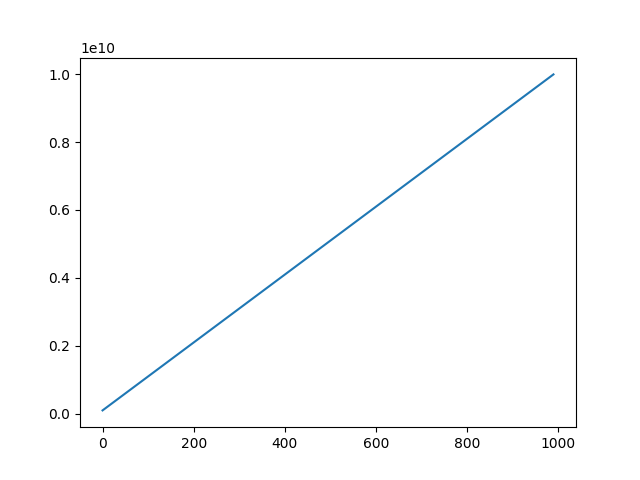

In [590]:
plt.close()
plt.plot(frequency)
plt.show()

In [585]:
current.shape

(70,)

In [589]:
70*990*3

207900

In [580]:
list_current = np.unique(current)

In [ ]:
np.array(data.ZNL14_S21_magnitude).reshape(len(current_vec),len(freq_vec),3)